In [1]:
from collections import Counter

import pandas as pd
import regex as re
import numpy as np
from itertools import chain
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.metrics import fbeta_score

In [2]:
train_df = pd.read_csv('data/train_v2.csv')
test_df = pd.read_csv('data/test_v2.csv')

print('train_df size: {}, test_df size: {}'.format(train_df.shape, test_df.shape))

train_df size: (6027, 7), test_df size: (3826, 6)


In [3]:
# In this part, we find most frequent unigram
data = train_df[(train_df.category == 2)]['title']
#df = train_df[(train_df.category > 1) & (train_df.category != 3)]

cv = CountVectorizer()
data = cv.fit_transform(data)

tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(data)
word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))
sorted_word2 = sorted(word2tfidf.items(), key=lambda kv: kv[1], reverse=False)

def find_frequent_unigram(cat):
    data = train_df[(train_df.category == cat)]['title']
    cv = CountVectorizer()
    data = cv.fit_transform(data)
    
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(data)
    word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))
    sorted_word2 = sorted(word2tfidf.items(), key=lambda kv: kv[1], reverse=False)
    fp = 'data/cat-{}-frequent.txt'.format(cat)
    with open(fp, 'w+') as wf:
        wf.write('word, idf\n')
        for item in sorted_word2:
            wf.write('{}, {}\n'.format(item[0], item[1]))
    print('done')
            

find_frequent_unigram(0)
find_frequent_unigram(1)
find_frequent_unigram(2)
find_frequent_unigram(3)
find_frequent_unigram(4)


# 有一些stopwords 不能去掉，例如 down

done
done
done
done
done


In [4]:
cat_2_word = pd.read_csv('data/cat-2-frequent.txt')['word'].values
cat_4_word = pd.read_csv('data/cat-4-frequent.txt')['word'].values
print(cat_2_word[: 10], cat_4_word[: 10])
intersection_2_4 = [item for item in cat_2_word if item in cat_4_word]
residual_2_4 = [item for item in cat_2_word if item not in cat_4_word]
print('cat-2: {}, cat_4: {}, intersection: {}'.format(len(cat_2_word), len(cat_4_word), len(intersection_2_4)))

def calculate_intersection():
    for i in range(4):
        cat = pd.read_csv('data/cat-{}-frequent.txt'.format(i))['word'].values
        cat_4 = pd.read_csv('data/cat-{}-frequent.txt'.format(4))['word'].values
        intersection = [item for item in cat if item in cat_4]
        print('cat{} unique word: {}, cat_4 unique word: {}, intersection word: {}, intersection percentage: {}'.format(i, len(cat), len(cat_4), len(intersection), len(intersection) / float(len(cat))))
        
#calculate_intersection()
#print(intersection_2_4[: 200])
#print('---')
#print(residual_2_4[: 200])


['to' 'in' 'for' 'on' 'us' 'of' 'video' 'china' 'the' 'billion'] ['to' 'in' 'of' 'for' 'on' 'the' 'us' 'china' 'missing' 'plane']
cat-2: 2605, cat_4: 3828, intersection: 1731


0


/diskA/yisong/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/diskA/yisong/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


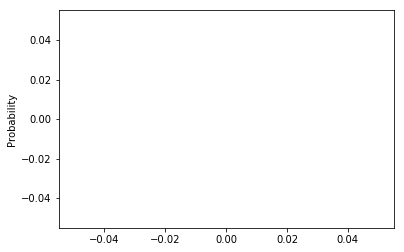

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem.porter import *
stemmer = PorterStemmer()

#print(stemmer.stem('obamacare')) 得到 obamacar

# 在这里，把 obamacar 当作 stopword!
manual_stopwords = ['obamacar']

def my_tokenizer(s):
    words = re.findall(r'[A-Za-z]+', s)
    words = [word.lower() for word in words]
    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if (len(word) > 1 and word not in manual_stopwords)]
    return words


def show_tokenizer():
    tag = []
    for i in range(train_df.shape[0]):
        #if i % 100 != 1:
        #    continue
        title = train_df.iloc[i]['title']
        title_ = my_tokenizer(title)
        #print('title: {}\n{}'.format(train_df.iloc[i]['title'], title_))
        if 'obamacar' in title_:
            #print('tag: {}\n{}'.format(train_df.iloc[i]['category'], title_))
            tag.append(train_df.iloc[i]['category'])
    print(len(tag))
    plt.hist(tag, normed=True, bins=5)
    plt.ylabel('Probability')
    plt.show()


show_tokenizer()

In [16]:
def find_obamacare():
    index = []
    for i in range(test_df.shape[0]):
        title = train_df.iloc[i]['title']
        title_ = my_tokenizer(title)
        if 'obamacar' in title_:
            index.append(i)
    return index


obama_index = find_obamacare()

In [17]:
X = train_df['title']
y = train_df['category']

#X = train_df[((train_df.category == 2) | (train_df.category == 4))]['title']
#y = train_df[((train_df.category == 2) | (train_df.category == 4))]['category']
print(X.shape, y.shape)

text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), tokenizer=my_tokenizer, stop_words='english')),
                      ('tfidf', TfidfTransformer(use_idf=True)),
                      ('clf-svm', SGDClassifier(alpha=0.001, loss='hinge', penalty='l2', warm_start=True, n_iter=6, random_state=42)),])

#('clf-lr', LogisticRegression(C=1, fit_intercept=True, penalty='l2', tol=0.01))
#('clf-svm', SGDClassifier(alpha=0.001, loss='hinge', penalty='l2', warm_start=True, n_iter=6, random_state=42))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

text_clf_svm = text_clf_svm.fit(X_train.values.astype('U'), y_train.values)
print('fit done')

result = text_clf_svm.predict(X_test)
print('f1 score is:{}'.format(fbeta_score(y_test, result, average='micro', beta=1)))

scores = cross_val_score(text_clf_svm, X.values.astype('U'), y, cv=5, scoring='f1_micro')
print(scores, np.mean(scores))

(6027,) (6027,)


/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


fit done
f1 score is:0.6699834162520729


/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/diskA/yisong/anaconda3/lib/python3.

[0.50662252 0.513267   0.56799337 0.73504983 0.90024938] 0.6446364183688786


/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


fit done


/diskA/yisong/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


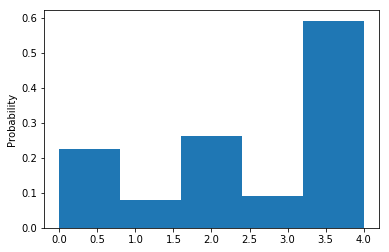

[]


/diskA/yisong/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


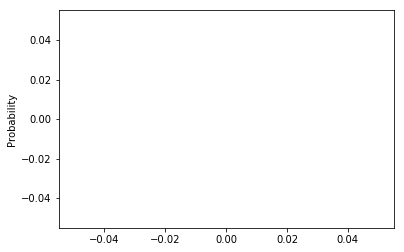

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# for submit
X_test = test_df['title']

text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), tokenizer=my_tokenizer, stop_words='english')),
                      ('tfidf', TfidfTransformer(use_idf=True)),
                      ('clf-svm', SGDClassifier(alpha=0.001, loss='hinge', penalty='l2', warm_start=True, n_iter=6, random_state=42))])

#('NB', MultinomialNB(alpha=0.1, fit_prior=True))
#('clf-lr', LogisticRegression(C=1, fit_intercept=True, penalty='l2', tol=0.01))
#('clf-svm', SGDClassifier(alpha=0.001, loss='hinge', penalty='l2', warm_start=True, n_iter=6, random_state=42))
text_clf_svm = text_clf_svm.fit(X.values.astype('U'), y.values)
print('fit done')

result = text_clf_svm.predict(X_test)

write_file = open('improvement-v2.txt', 'w+')
write_file.write('article_id,category\n')
i = 1
for item in result:
    write_file.write('{},{}\n'.format(i, item))
    i += 1
write_file.close()

plt.hist(result, normed=True, bins=5)
plt.ylabel('Probability')
plt.show()

obama_result = []
for index, item in enumerate(result):
    if index in obama_index:
        obama_result.append(item)

print(obama_result)
plt.hist(obama_result, normed=True, bins=5)
plt.ylabel('Probability')
plt.show()
        